In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Activation
import tensorflow as tf

In [2]:
df = pd.read_csv('earning_wt_price.csv',index_col = 0 ,parse_dates = True)
df = df.drop(['ESP'],axis = 1)
df = df.dropna()
df = df[df['cap']>7000]
df['open_2d'] = df['open_2d'].map(float)
df = df.loc['2020']

#df['timing'] = np.where(df['timing'] =='bmo',0,1)
df['close_ret'] = df['close']/df['before'] - 1
df['spy_ret'] = df['spy_after']/df['spy_before'] - 1
df['after'] = df['after']/df['before'] - 1
df['target'] = df['cons']+df['beta']*df['spy_ret']
df['alpha'] = df['after'] - df['target']
df['earn_surp'] = df['Reported_eps'] - df['Estimate_eps']
df['sales_ratio'] = df['Reported_sales']/df['cap']
df['sales_surp'] = df['Reported_sales']/df['Estimate_sales'] - 1
df['open_ret'] = df['open_2d']/df['before'] - 1
corr = df.corr()
corr['open_ret'].abs().sort_values(ascending = False)

open_ret          1.000000
close_ret         0.950391
after             0.764737
alpha             0.744178
spy_ret           0.242654
target            0.231002
cons              0.183500
macd_before       0.124214
spy_before        0.104975
spy_after         0.068333
earn_surp         0.058999
sales_surp        0.040383
Estimate_eps      0.030151
Estimate_sales    0.030128
Reported_sales    0.028517
sales_ratio       0.025243
open_2d           0.021557
r2                0.021476
close             0.019169
low               0.013609
cap               0.013392
beta              0.012709
macd_after        0.011987
Reported_eps      0.011220
before            0.010342
dev               0.001548
Name: open_ret, dtype: float64

In [4]:
#xcol = corr['open_ret'].abs().sort_values(ascending = False).index[2:]
#xcol = ['after', 'alpha','spy_ret','target','macd_before','cons','spy_before','spy_after','earn_surp','sales_surp']
xcol = ['after', 'alpha', 'before', 'open_2d', 'macd_before', 'macd_after',
       'close', 'cons', 'Reported_eps', 'Estimate_eps', 'target', 'beta','r2']

X = df[xcol]
y = df['open_ret']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

x_scaler = StandardScaler().fit(X_train)
X_train = x_scaler.transform(X_train)
X_test = x_scaler.transform(X_test)

y_scaler = StandardScaler().fit(y_train.to_numpy().reshape(-1,1))
y_train = y_scaler.transform(y_train.to_numpy().reshape(-1,1))
y_test = y_scaler.transform(y_test.to_numpy().reshape(-1,1))

In [6]:
lin = sm.OLS(pd.DataFrame([x[0] for x in y_train]),sm.add_constant(pd.DataFrame(X_train, columns = xcol))).fit()
lin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      0   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     237.7
Date:                Wed, 29 Jul 2020   Prob (F-statistic):          1.83e-298
Time:                        17:53:30   Log-Likelihood:                -898.57
No. Observations:                1140   AIC:                             1823.
Df Residuals:                    1127   BIC:                             1889.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.561e-17      0.016   9.85e-16      1.000      -0.031       0.031
after            0.3558      0.009     39.187      0.000       0.338       0.374
alpha            0.3450      0.010     33.321      0.000       0.325       0.365
before          -5.8143      0.369    -15.741      0.000      -6.539      -5.090
open_2d         13.9770      1.042     13.413      0.000      11.932      16.022
macd_before     -0.6001      0.058    -10.339      0.000      -0.714      -0.486
macd_after       0.4998      0.056      8.861      0.000       0.389       0.610
close           -8.2194      1.071     -7.673      0.000     -10.321      -6.118
cons            -0.1100      0.019     -5.837      0.000      -0.147      -0.073
Reported_eps    -0.0467      0.057     -0.816      0.415      -0.159       0.066
Estimate_eps     0.0980      0.062      1.570      0.117      -0.024       0.221
target           0.1147      0.016      7.074      0.000       0.083       0.147
beta             0.0494      0.020      2.456      0.014       0.010       0.089
r2              -0.0406      0.019     -2.156      0.031      -0.078      -0.004
==============================================================================
Omnibus:                      195.587   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1189.961
Skew:                           0.637   Prob(JB):                    4.01e-259
Kurtosis:                       7.840   Cond. No.                     1.31e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.03e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [11]:
model = Sequential()
model.add(Dense(X_train.shape[1], activation = 'relu',input_shape = [X_train.shape[1],]))
model.add(Dense(64,activation = 'relu'))
model.add(Dense(1))
model.compile(loss = 'mae',optimizer = 'rmsprop',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

model.fit(X_train, y_train,validation_split = 0.33,epochs=1000,batch_size = 100)

Epoch 1/1000
8/8 [==============================] - 0s 18ms/step - loss: 0.6396 - mean_absolute_error: 0.6396 - val_loss: 0.5305 - val_mean_absolute_error: 0.5305
Epoch 2/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.5357 - mean_absolute_error: 0.5357 - val_loss: 0.5177 - val_mean_absolute_error: 0.5177
Epoch 3/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.5024 - mean_absolute_error: 0.5024 - val_loss: 0.5101 - val_mean_absolute_error: 0.5101
Epoch 4/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.4939 - mean_absolute_error: 0.4939 - val_loss: 0.5141 - val_mean_absolute_error: 0.5141
Epoch 5/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.4859 - mean_absolute_error: 0.4859 - val_loss: 0.5154 - val_mean_absolute_error: 0.5154
Epoch 6/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.4803 - mean_absolute_error: 0.4803 - val_loss: 0.5034 - val_mean_absolute_error: 0.5034
Epoch 7/1000
8/8 [=========

8/8 [==============================] - 0s 2ms/step - loss: 0.4186 - mean_absolute_error: 0.4186 - val_loss: 0.5153 - val_mean_absolute_error: 0.5153
Epoch 52/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.4147 - mean_absolute_error: 0.4147 - val_loss: 0.4990 - val_mean_absolute_error: 0.4990
Epoch 53/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.4146 - mean_absolute_error: 0.4146 - val_loss: 0.5025 - val_mean_absolute_error: 0.5025
Epoch 54/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.4090 - mean_absolute_error: 0.4090 - val_loss: 0.5101 - val_mean_absolute_error: 0.5101
Epoch 55/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.4146 - mean_absolute_error: 0.4146 - val_loss: 0.5121 - val_mean_absolute_error: 0.5121
Epoch 56/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.4093 - mean_absolute_error: 0.4093 - val_loss: 0.5122 - val_mean_absolute_error: 0.5122
Epoch 57/1000
8/8 [=================

8/8 [==============================] - 0s 2ms/step - loss: 0.3628 - mean_absolute_error: 0.3628 - val_loss: 0.5261 - val_mean_absolute_error: 0.5261
Epoch 102/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.3558 - mean_absolute_error: 0.3558 - val_loss: 0.5362 - val_mean_absolute_error: 0.5362
Epoch 103/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.3653 - mean_absolute_error: 0.3653 - val_loss: 0.5646 - val_mean_absolute_error: 0.5646
Epoch 104/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.3593 - mean_absolute_error: 0.3593 - val_loss: 0.5425 - val_mean_absolute_error: 0.5425
Epoch 105/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.3588 - mean_absolute_error: 0.3588 - val_loss: 0.5391 - val_mean_absolute_error: 0.5391
Epoch 106/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.3605 - mean_absolute_error: 0.3605 - val_loss: 0.5326 - val_mean_absolute_error: 0.5326
Epoch 107/1000
8/8 [===========

8/8 [==============================] - 0s 2ms/step - loss: 0.3221 - mean_absolute_error: 0.3221 - val_loss: 0.5674 - val_mean_absolute_error: 0.5674
Epoch 152/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.3190 - mean_absolute_error: 0.3190 - val_loss: 0.5489 - val_mean_absolute_error: 0.5489
Epoch 153/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.3373 - mean_absolute_error: 0.3373 - val_loss: 0.5480 - val_mean_absolute_error: 0.5480
Epoch 154/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.3198 - mean_absolute_error: 0.3198 - val_loss: 0.5694 - val_mean_absolute_error: 0.5694
Epoch 155/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.3219 - mean_absolute_error: 0.3219 - val_loss: 0.5499 - val_mean_absolute_error: 0.5499
Epoch 156/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.3180 - mean_absolute_error: 0.3180 - val_loss: 0.5448 - val_mean_absolute_error: 0.5448
Epoch 157/1000
8/8 [===========

8/8 [==============================] - 0s 2ms/step - loss: 0.2986 - mean_absolute_error: 0.2986 - val_loss: 0.5679 - val_mean_absolute_error: 0.5679
Epoch 202/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2839 - mean_absolute_error: 0.2839 - val_loss: 0.5507 - val_mean_absolute_error: 0.5507
Epoch 203/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2970 - mean_absolute_error: 0.2970 - val_loss: 0.5530 - val_mean_absolute_error: 0.5530
Epoch 204/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2936 - mean_absolute_error: 0.2936 - val_loss: 0.5710 - val_mean_absolute_error: 0.5710
Epoch 205/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2961 - mean_absolute_error: 0.2961 - val_loss: 0.5628 - val_mean_absolute_error: 0.5628
Epoch 206/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2965 - mean_absolute_error: 0.2965 - val_loss: 0.5557 - val_mean_absolute_error: 0.5557
Epoch 207/1000
8/8 [===========

8/8 [==============================] - 0s 2ms/step - loss: 0.2793 - mean_absolute_error: 0.2793 - val_loss: 0.5791 - val_mean_absolute_error: 0.5791
Epoch 252/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2634 - mean_absolute_error: 0.2634 - val_loss: 0.5744 - val_mean_absolute_error: 0.5744
Epoch 253/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2872 - mean_absolute_error: 0.2872 - val_loss: 0.5592 - val_mean_absolute_error: 0.5592
Epoch 254/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2717 - mean_absolute_error: 0.2717 - val_loss: 0.5967 - val_mean_absolute_error: 0.5967
Epoch 255/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2715 - mean_absolute_error: 0.2715 - val_loss: 0.6017 - val_mean_absolute_error: 0.6017
Epoch 256/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2817 - mean_absolute_error: 0.2817 - val_loss: 0.5937 - val_mean_absolute_error: 0.5937
Epoch 257/1000
8/8 [===========

8/8 [==============================] - 0s 2ms/step - loss: 0.2464 - mean_absolute_error: 0.2464 - val_loss: 0.6347 - val_mean_absolute_error: 0.6347
Epoch 302/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2600 - mean_absolute_error: 0.2600 - val_loss: 0.5962 - val_mean_absolute_error: 0.5962
Epoch 303/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2539 - mean_absolute_error: 0.2539 - val_loss: 0.5934 - val_mean_absolute_error: 0.5934
Epoch 304/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2477 - mean_absolute_error: 0.2477 - val_loss: 0.5867 - val_mean_absolute_error: 0.5867
Epoch 305/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2458 - mean_absolute_error: 0.2458 - val_loss: 0.5967 - val_mean_absolute_error: 0.5967
Epoch 306/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2535 - mean_absolute_error: 0.2535 - val_loss: 0.6190 - val_mean_absolute_error: 0.6190
Epoch 307/1000
8/8 [===========

8/8 [==============================] - 0s 2ms/step - loss: 0.2363 - mean_absolute_error: 0.2363 - val_loss: 0.5952 - val_mean_absolute_error: 0.5952
Epoch 352/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2489 - mean_absolute_error: 0.2489 - val_loss: 0.6143 - val_mean_absolute_error: 0.6143
Epoch 353/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2473 - mean_absolute_error: 0.2473 - val_loss: 0.6240 - val_mean_absolute_error: 0.6240
Epoch 354/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2443 - mean_absolute_error: 0.2443 - val_loss: 0.6145 - val_mean_absolute_error: 0.6145
Epoch 355/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2232 - mean_absolute_error: 0.2232 - val_loss: 0.6440 - val_mean_absolute_error: 0.6440
Epoch 356/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2567 - mean_absolute_error: 0.2567 - val_loss: 0.6385 - val_mean_absolute_error: 0.6385
Epoch 357/1000
8/8 [===========

8/8 [==============================] - 0s 2ms/step - loss: 0.2164 - mean_absolute_error: 0.2164 - val_loss: 0.6098 - val_mean_absolute_error: 0.6098
Epoch 402/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2287 - mean_absolute_error: 0.2287 - val_loss: 0.6117 - val_mean_absolute_error: 0.6117
Epoch 403/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2278 - mean_absolute_error: 0.2278 - val_loss: 0.6155 - val_mean_absolute_error: 0.6155
Epoch 404/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2269 - mean_absolute_error: 0.2269 - val_loss: 0.6309 - val_mean_absolute_error: 0.6309
Epoch 405/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2289 - mean_absolute_error: 0.2289 - val_loss: 0.6380 - val_mean_absolute_error: 0.6380
Epoch 406/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2179 - mean_absolute_error: 0.2179 - val_loss: 0.6344 - val_mean_absolute_error: 0.6344
Epoch 407/1000
8/8 [===========

8/8 [==============================] - 0s 2ms/step - loss: 0.2173 - mean_absolute_error: 0.2173 - val_loss: 0.6254 - val_mean_absolute_error: 0.6254
Epoch 452/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2256 - mean_absolute_error: 0.2256 - val_loss: 0.6126 - val_mean_absolute_error: 0.6126
Epoch 453/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2072 - mean_absolute_error: 0.2072 - val_loss: 0.6176 - val_mean_absolute_error: 0.6176
Epoch 454/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2199 - mean_absolute_error: 0.2199 - val_loss: 0.6196 - val_mean_absolute_error: 0.6196
Epoch 455/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1879 - mean_absolute_error: 0.1879 - val_loss: 0.6048 - val_mean_absolute_error: 0.6048
Epoch 456/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2375 - mean_absolute_error: 0.2375 - val_loss: 0.6297 - val_mean_absolute_error: 0.6297
Epoch 457/1000
8/8 [===========

8/8 [==============================] - 0s 2ms/step - loss: 0.2083 - mean_absolute_error: 0.2083 - val_loss: 0.6414 - val_mean_absolute_error: 0.6414
Epoch 502/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2099 - mean_absolute_error: 0.2099 - val_loss: 0.6292 - val_mean_absolute_error: 0.6292
Epoch 503/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2058 - mean_absolute_error: 0.2058 - val_loss: 0.6513 - val_mean_absolute_error: 0.6513
Epoch 504/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2055 - mean_absolute_error: 0.2055 - val_loss: 0.6346 - val_mean_absolute_error: 0.6346
Epoch 505/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2061 - mean_absolute_error: 0.2061 - val_loss: 0.6384 - val_mean_absolute_error: 0.6384
Epoch 506/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2101 - mean_absolute_error: 0.2101 - val_loss: 0.6349 - val_mean_absolute_error: 0.6349
Epoch 507/1000
8/8 [===========

8/8 [==============================] - 0s 2ms/step - loss: 0.2086 - mean_absolute_error: 0.2086 - val_loss: 0.6381 - val_mean_absolute_error: 0.6381
Epoch 552/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1822 - mean_absolute_error: 0.1822 - val_loss: 0.6231 - val_mean_absolute_error: 0.6231
Epoch 553/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1816 - mean_absolute_error: 0.1816 - val_loss: 0.6347 - val_mean_absolute_error: 0.6347
Epoch 554/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.2015 - mean_absolute_error: 0.2015 - val_loss: 0.6084 - val_mean_absolute_error: 0.6084
Epoch 555/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1715 - mean_absolute_error: 0.1715 - val_loss: 0.6625 - val_mean_absolute_error: 0.6625
Epoch 556/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1875 - mean_absolute_error: 0.1875 - val_loss: 0.6244 - val_mean_absolute_error: 0.6244
Epoch 557/1000
8/8 [===========

8/8 [==============================] - 0s 2ms/step - loss: 0.1919 - mean_absolute_error: 0.1919 - val_loss: 0.6203 - val_mean_absolute_error: 0.6203
Epoch 602/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1875 - mean_absolute_error: 0.1875 - val_loss: 0.6147 - val_mean_absolute_error: 0.6147
Epoch 603/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1964 - mean_absolute_error: 0.1964 - val_loss: 0.6286 - val_mean_absolute_error: 0.6286
Epoch 604/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1820 - mean_absolute_error: 0.1820 - val_loss: 0.6257 - val_mean_absolute_error: 0.6257
Epoch 605/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1990 - mean_absolute_error: 0.1990 - val_loss: 0.6202 - val_mean_absolute_error: 0.6202
Epoch 606/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1787 - mean_absolute_error: 0.1787 - val_loss: 0.6232 - val_mean_absolute_error: 0.6232
Epoch 607/1000
8/8 [===========

8/8 [==============================] - 0s 2ms/step - loss: 0.1582 - mean_absolute_error: 0.1582 - val_loss: 0.6286 - val_mean_absolute_error: 0.6286
Epoch 652/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1905 - mean_absolute_error: 0.1905 - val_loss: 0.6272 - val_mean_absolute_error: 0.6272
Epoch 653/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1565 - mean_absolute_error: 0.1565 - val_loss: 0.6262 - val_mean_absolute_error: 0.6262
Epoch 654/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1934 - mean_absolute_error: 0.1934 - val_loss: 0.6335 - val_mean_absolute_error: 0.6335
Epoch 655/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1680 - mean_absolute_error: 0.1680 - val_loss: 0.6289 - val_mean_absolute_error: 0.6289
Epoch 656/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1843 - mean_absolute_error: 0.1843 - val_loss: 0.6439 - val_mean_absolute_error: 0.6439
Epoch 657/1000
8/8 [===========

8/8 [==============================] - 0s 2ms/step - loss: 0.1767 - mean_absolute_error: 0.1767 - val_loss: 0.6299 - val_mean_absolute_error: 0.6299
Epoch 702/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1626 - mean_absolute_error: 0.1626 - val_loss: 0.6329 - val_mean_absolute_error: 0.6329
Epoch 703/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1694 - mean_absolute_error: 0.1694 - val_loss: 0.6392 - val_mean_absolute_error: 0.6392
Epoch 704/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1704 - mean_absolute_error: 0.1704 - val_loss: 0.6459 - val_mean_absolute_error: 0.6459
Epoch 705/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1584 - mean_absolute_error: 0.1584 - val_loss: 0.6538 - val_mean_absolute_error: 0.6538
Epoch 706/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1756 - mean_absolute_error: 0.1756 - val_loss: 0.6484 - val_mean_absolute_error: 0.6484
Epoch 707/1000
8/8 [===========

8/8 [==============================] - 0s 2ms/step - loss: 0.1735 - mean_absolute_error: 0.1735 - val_loss: 0.6234 - val_mean_absolute_error: 0.6234
Epoch 752/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1575 - mean_absolute_error: 0.1575 - val_loss: 0.6412 - val_mean_absolute_error: 0.6412
Epoch 753/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1618 - mean_absolute_error: 0.1618 - val_loss: 0.6587 - val_mean_absolute_error: 0.6587
Epoch 754/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1709 - mean_absolute_error: 0.1709 - val_loss: 0.6652 - val_mean_absolute_error: 0.6652
Epoch 755/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1796 - mean_absolute_error: 0.1796 - val_loss: 0.6431 - val_mean_absolute_error: 0.6431
Epoch 756/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1388 - mean_absolute_error: 0.1388 - val_loss: 0.6644 - val_mean_absolute_error: 0.6644
Epoch 757/1000
8/8 [===========

8/8 [==============================] - 0s 2ms/step - loss: 0.1665 - mean_absolute_error: 0.1665 - val_loss: 0.6444 - val_mean_absolute_error: 0.6444
Epoch 802/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1504 - mean_absolute_error: 0.1504 - val_loss: 0.6411 - val_mean_absolute_error: 0.6411
Epoch 803/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1533 - mean_absolute_error: 0.1533 - val_loss: 0.6342 - val_mean_absolute_error: 0.6342
Epoch 804/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1582 - mean_absolute_error: 0.1582 - val_loss: 0.6384 - val_mean_absolute_error: 0.6384
Epoch 805/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1572 - mean_absolute_error: 0.1572 - val_loss: 0.6386 - val_mean_absolute_error: 0.6386
Epoch 806/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1638 - mean_absolute_error: 0.1638 - val_loss: 0.6362 - val_mean_absolute_error: 0.6362
Epoch 807/1000
8/8 [===========

8/8 [==============================] - 0s 2ms/step - loss: 0.1506 - mean_absolute_error: 0.1506 - val_loss: 0.6290 - val_mean_absolute_error: 0.6290
Epoch 852/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1621 - mean_absolute_error: 0.1621 - val_loss: 0.6366 - val_mean_absolute_error: 0.6366
Epoch 853/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1486 - mean_absolute_error: 0.1486 - val_loss: 0.6752 - val_mean_absolute_error: 0.6752
Epoch 854/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1641 - mean_absolute_error: 0.1641 - val_loss: 0.6525 - val_mean_absolute_error: 0.6525
Epoch 855/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1260 - mean_absolute_error: 0.1260 - val_loss: 0.6451 - val_mean_absolute_error: 0.6451
Epoch 856/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1723 - mean_absolute_error: 0.1723 - val_loss: 0.6462 - val_mean_absolute_error: 0.6462
Epoch 857/1000
8/8 [===========

8/8 [==============================] - 0s 2ms/step - loss: 0.1550 - mean_absolute_error: 0.1550 - val_loss: 0.6677 - val_mean_absolute_error: 0.6677
Epoch 902/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1482 - mean_absolute_error: 0.1482 - val_loss: 0.6640 - val_mean_absolute_error: 0.6640
Epoch 903/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1607 - mean_absolute_error: 0.1607 - val_loss: 0.6675 - val_mean_absolute_error: 0.6675
Epoch 904/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1428 - mean_absolute_error: 0.1428 - val_loss: 0.6630 - val_mean_absolute_error: 0.6630
Epoch 905/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1318 - mean_absolute_error: 0.1318 - val_loss: 0.6577 - val_mean_absolute_error: 0.6577
Epoch 906/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1589 - mean_absolute_error: 0.1589 - val_loss: 0.6559 - val_mean_absolute_error: 0.6559
Epoch 907/1000
8/8 [===========

8/8 [==============================] - 0s 2ms/step - loss: 0.1521 - mean_absolute_error: 0.1521 - val_loss: 0.6418 - val_mean_absolute_error: 0.6418
Epoch 952/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1476 - mean_absolute_error: 0.1476 - val_loss: 0.6502 - val_mean_absolute_error: 0.6502
Epoch 953/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1385 - mean_absolute_error: 0.1385 - val_loss: 0.6409 - val_mean_absolute_error: 0.6409
Epoch 954/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1377 - mean_absolute_error: 0.1377 - val_loss: 0.6322 - val_mean_absolute_error: 0.6322
Epoch 955/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1386 - mean_absolute_error: 0.1386 - val_loss: 0.6453 - val_mean_absolute_error: 0.6453
Epoch 956/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.1394 - mean_absolute_error: 0.1394 - val_loss: 0.6427 - val_mean_absolute_error: 0.6427
Epoch 957/1000
8/8 [===========

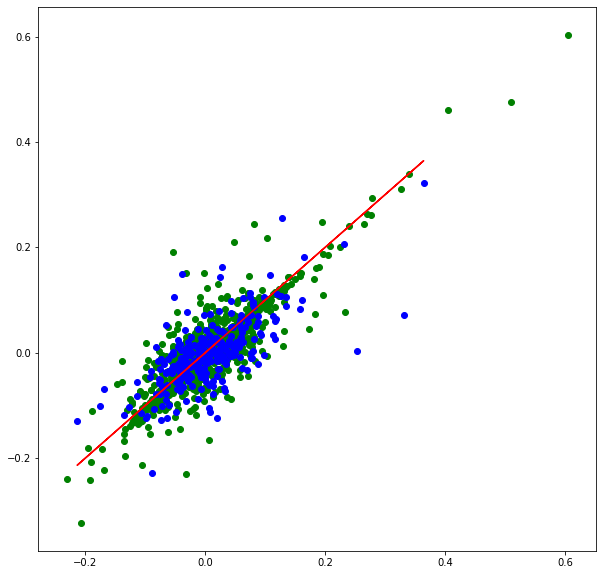

count    1426.000000
mean        0.024044
std         0.030496
min         0.000008
25%         0.004415
50%         0.011762
75%         0.032980
max         0.260509
Name: resid, dtype: float64

In [12]:
Y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
plt.figure(figsize = (10,10))
plt.scatter(y_scaler.inverse_transform(y_train),y_scaler.inverse_transform(y_train_pred),c = 'green')
plt.scatter(y_scaler.inverse_transform(y_test),y_scaler.inverse_transform(Y_pred),c = 'blue')
plt.plot(y_scaler.inverse_transform(y_test),y_scaler.inverse_transform(y_test),color = 'r')
plt.show()

df['pred'] = y_scaler.inverse_transform(model.predict(x_scaler.transform(df[xcol])))
df['resid'] = (df['pred'] - df['open_ret'])
df['resid'].describe()
df['resid'].abs().describe()